# Estimate so2 as a function of  financial ratio (add city-level, Estimate by city-industry)

# US Name

Estimate so2 as a function of  financial ratio (add city-level, Estimate by city-industry) 

# Business needs 

Estimate so2 as a function of  financial ratio (Add city-industry financial ratio level, Pull estimate using financial ratio at the city-industry) 

## Description
### Objective 

Test the coefficient sign and significant of the main variable

### Tables

1. Table 1: Baseline Estimate, so2 and financial ratio

**Cautious**
* Make sure no empty rows, otherwise it will be filtered out in the estimate


# Metadata

* Key: srj15wnkj21653b
* Parent key (for update parent):  
* Epic: Models
* US: Sector by sector
* Task tag: #analytics,#econometrics,#sector-estimate
* Notebook US Parent (i.e the one to update): 
https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/02_data_analysis/01_model_estimation/00_estimate_fin_ratio/03_so2_fin_ratio_sector.md
* Reports: https://htmlpreview.github.io/?https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/02_data_analysis/01_model_estimation/00_estimate_fin_ratio/Reports/03_so2_fin_ratio_sector.html
* Analytics reports:
 

# Input Cloud Storage [AWS/GCP]

## Table/file
* Name: 
* fin_dep_pollution_baseline_city
* Github: 
  * https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/04_fin_dep_pol_baseline_city.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'environment'
table = 'fin_dep_pollution_baseline_city'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [8]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    WHERE 
      year in (
        '2001', '2002', '2003', '2004', '2005', 
        '2006', '2007'
      ) 
      AND 
      lag_current_ratio > 0 
      AND
      lag_cashflow_to_tangible > 0 
      AND 
      tfp_cit > 0
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
            )
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [9]:
pd.DataFrame(schema)

,Name,Type,Comment
0,year,string,year from 2001 to 2007
1,period,varchar(5),"False if year before 2005 included, True if year 2006 and 2007"
2,province_en,string,
3,geocode4_corr,string,
4,tcz,string,Two control zone policy city
...,...,...,...
80,dominated_sales_for_i,"map<double,boolean>","map with information on foreign dominated industry knowing percentile .5, .75, .9, .95 of sales"
81,dominated_capital_for_i,"map<double,boolean>","map with information on foreign dominated industry knowing percentile .5, .75, .9, .95 of capital"
82,fe_c_i,bigint,City industry fixed effect
83,fe_t_i,bigint,year industry fixed effect


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [10]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
        data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        ### depd
        {
        'old':'total\_asset',
        'new':'\\text{total asset}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{asset tangibility}'
        },
        
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'lag\_current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'lag\_liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'lag\_sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'lag\_cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'supply\_long\_term\_credit',
        'new':'\\text{long term credit}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit demand}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
        ## TFP
        {
        'old':'tfp\_cit',
        'new':'\\text{TFP}'
        }
        
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [11]:
import sys
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb

#%load_ext autoreload
#%autoreload 2

In [12]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [13]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE'),
    polluted_d50i = relevel(as.factor(polluted_d50i), ref='BELOW'),
    polluted_d75i = relevel(as.factor(polluted_d75i), ref='BELOW'),
    polluted_d80i = relevel(as.factor(polluted_d80i), ref='BELOW'),
    polluted_d85i = relevel(as.factor(polluted_d85i), ref='BELOW'),
    polluted_d90i = relevel(as.factor(polluted_d90i), ref='BELOW'),
    polluted_d95i = relevel(as.factor(polluted_d95i), ref='BELOW'),
    polluted_mi = relevel(as.factor(polluted_mi), ref='BELOW')  
)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  province_en = col_character(),
  short = col_character(),
  polluted_d50i = col_character(),
  polluted_d75i = col_character(),
  polluted_d80i = col_character(),
  polluted_d85i = col_character(),
  polluted_d90i = col_character(),
  polluted_d95i = col_character(),
  polluted_mi = col_character(),
  polluted_d50_cit = col_character(),
  polluted_d75_cit = col_character(),
  polluted_d80_cit = col_character(),
  polluted_d85_cit = col_character(),
  polluted_d90_cit = col_character(),
  polluted_d95_cit = col_character(),
  polluted_m_cit = col_character(),
  above_threshold_mandate = col_character(),
  above_average_mandate = col_character(),
  dominated_output_soe_c = col_logical()
  # ... with 19 more columns
)
See spec(...) for full column specifications.


# Expected signs

| index | Metrics                        | comments                                                                                                    | variables                                                                                                                                                           | Roam_link                                       | Exepected sign              | Comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|-------|--------------------------------|-------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------|-----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1     | External finance dependence    | From #[[Fan et al. 2015 - Credit constraints, quality, and export prices - Theory and evidence from China]] |                                                                                                                                                                     | #external-finance-dependence                    | Negative                    | An industry’s external finance dependence (ExtFini) is defined as the share of capital expenditure not financed with cash flows from operations. If external finance dependence is high, the industry is more financially vulnerable and have higher credit needs                                                                                                                                                                                                                                                                              |
| 2     | R&D intensity                  | RD / Sales                                                                                                  | rdfee/sales                                                                                                                                                         | #rd-intensity                                   | Negative                    | Share of RD expenditure over sales. larger values indicates larger use of sales to spend on RD. Say differently, lower borrowing done toward RD                                                                                                                                                                                                                                                                                                                                                                                                |
| 3     | Inventory to sales             | Inventory / sales                                                                                           | 存货 (c81) / sales                                                                                                                                                  | #inventory-to-sales                             | Negative                    | Share of inventory over sales. Larger values indicates share of unsold or not consumed items. large values is a demonstration of tighter credit constraint                                                                                                                                                                                                                                                                                                                                                                                     |
| 4     | % receivable                   | receivable account / current asset                                                                          | 应收帐款 (c80) / cuasset                                                                                                                                            | #account-receivable #current-asset              | Negative                    | Share of receivable over current asset. Larger value indicates longer time before collecting the money from the customers                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 5     | Liabilities over asset         | (Short-Tern Debt + Long-Term Debt)/total asset                                                              | (流动负债合计 (c95) + 长期负债合计 (c97)) / toasset                                                                                                                 | #total-debt-to-total-assets                     | Negative                    | Share of liabilities over total asset. Larger value indicates assets that are financed by external creditors                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 6     | working capital requirement    | Inventory + Accounts receivable - Accounts payable                                                          | 存货 (c81) + 应收帐款 (c80) - 应付帐款  (c96)                                                                                                                       | #working-capital                                | Negative                    | Working Capital Requirement is the amount of money needed to finance the gap between disbursements (payments to suppliers) and receipts (payments from customers). Larger values indicate the amount of money needed to meet the debt.                                                                                                                                                                                                                                                                                                         |
| 7     | % cash                         | Current asset - cash / current asset                                                                        | (cuasset- 其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81) - 其中：产成品 (c82)) /current asset                                                                   | #current-asset #cash                            | Positive                    | Share of cash asset over current asset. Larger values indicate more cash in hand.                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
|       | Cash over asset                | Current asset - cash / total asset                                                                          | (cuasset- 其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81) - 其中：产成品 (c82)) /toasset                                                                         | #current-asset #cash                            | Positive                    | Share of cash asset over total asset. Larger values indicate more cash in hand.                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 8     | cash ratio                     | (Cash + marketable securities)/current liabilities                                                          | 1-(cuasset - 其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81) - 其中：产成品 (c82))/ 流动负债合计 (c95)                                                           | #cash-asset #cash-ratio                         | Positive                    | Cash divided by liabilities. A portion of short-term debt that can be financed by cash. A larger value indicates the company generates enough cash to cope with the short term debt                                                                                                                                                                                                                                                                                                                                                            |
| 9     | Working capital                | Current asset - current liabilities                                                                         | cuasset- 流动负债合计 (c95)                                                                                                                                         | #working-capital-requirement                    | Positive                    | Difference between current asset and current liabilities. Larger value indicates that assets are enough to cope with the short term need                                                                                                                                                                                                                                                                                                                                                                                                       |
| 10    | current ratio                  | Current asset /current liabilities                                                                          | cuasset/流动负债合计 (c95)                                                                                                                                          | #current-ratio                                  | Ambiguous                   | Asset divided by liabilities. Values above 1 indicate there are more assets than liabilities. There are two effects on the liquidity constraint. Larger values imply the company has more liquidity, hence they may be less dependent on the formal financial market. By analogy, the financial market prefers to invest or provide money to the more liquid company (reduce the risk default)                                                                                                                                                 |
| 11    | Quick ratio                    | (Current asset - Inventory)/current liabilities                                                             | (cuasset -  其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81)) / 流动负债合计 (c95)                                                                                | #quick-ratio                                    | Ambiguous                   | The quick ratio is a measure of liquidity. The higher the more liquid the company is. To improve the ratio, the company should reduce the account receivable (reduce payment time) and increase the account payable (negotiate payment term). There are two effects on the liquidity constraint. Larger values imply the company has more liquidity, hence they may be less dependent on the formal financial market. By analogy, the financial market prefers to invest or provide money to the more liquid company (reduce the risk default) |
| 12    | Return on Asset                | Net income / Total assets                                                                                   | sales - (主营业务成本 (c108) + 营业费用 (c113) + 管理费用 (c114) + 财产保险费 (c116) + 劳动、失业保险费 (c118)+ 财务费用 (c124) + 本年应付工资总额 (wage)) /toasset | #return-on-asset                                | Ambiguous                   | Net income over total asset. Capacity of an asset to generate income. Larger value indicates that asset are used in an efficiente way to generate income                                                                                                                                                                                                                                                                                                                                                                                       |
| 13    | Asset Turnover Ratio           | Total sales / ((delta total asset)/2)                                                                       | 全年营业收入合计 (c64) /($\Delta$ toasset/2)                                                                                                                        | #asset-turnover-ratio                           | Ambiguous                   | Sales divided by the average changes in total asset. Larger value indicates better efficiency at using asset to generate revenue                                                                                                                                                                                                                                                                                                                                                                                                               |
| 14    | Sale over asset                | Total sales /total asset                                                                                    | 全年营业收入合计 (c64) /(toasset)                                                                                                                                   | #sale-over-asset                                | Ambiguous                   | Sales divided by total asset. Larger value indicates better efficiency at using asset to generate revenue                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 15    | Asset tangibility              | Total fixed assets - Intangible assets                                                                      | tofixed - 无形资产 (c92)                                                                                                                                            | #asset-tangibility                              | Ambiguous                   | Difference between fixed sset and intangible asset. Larger value indicates more collateral, hence higher borrowing capacity                                                                                                                                                                                                                                                                                                                                                                                                                    |
| 16    | Account payable to total asset | (delta account payable)/ (delta total asset)                                                                | ($\Delta$ 应付帐款  (c96))/ ($\Delta$$ (toasset))                                                                                                                   | #change-account-paybable-to-change-total-assets | Ambiguous (favour positive) | Variation of account payable over variation total asset. If the nominator larger than the denominator, it means the account payable grew larger than an asset, or more time is given to pay back the supplier relative to the total asset.  Say differently,  companies can more easily access buyer or supplier trade credit, they may be less dependent on the formal financial market                                                                                                                                                       |

## Table 1: Baseline Estimate, determinant of SO2 emission

$$\begin{aligned} \text{SO2}{cit} &= \alpha_1 \text{Asset Tangibility}_{cit} + \alpha_2 \text{Internal finance}_{cit-1}+ \alpha_3 \text{TFP}_{cit} + \beta \text{X}_{cit} + \gamma_{it} +\gamma_{ct} + \epsilon_{cit} \end{aligned}$$

The following variables are lagged:

- cashflow
- current ratio
- sale over asset

**Andersen results**

![](https://drive.google.com/uc?export=view&id=1HrqaA5NLRPjWk2lqvHyrZAjO3wSP5r-9)


Note that, in Andersen paper, the variables Assets and total Asset are the same. See :

"Asset Tangibility is defined, following Braun (2003) and Manova (2012), as the share of Net Property, Plant, and Equipment in Total Book-Value Assets. I use standard measures of credit constraints, including the Current Ratio (Current Assets to Current Liabilities) and the **Cash to Total Assets Ratio**. The ratio of **Total Liabilities to Total Assets** is employed as a proxy for long-run solvency. Additional controls include the Market to Book Ratio, the Sales to Assets Ratio, and Return on Assets (Earnings Before Interest and Taxes to Total Assets)."

It is not possible to include:

- Sales
- Total asset
- Sales to total asset -> Sales/Total asset

in the same regression. It is collinear. 

Andersen used the lagged of `Sales to total asset`, `current ratio`, `liabilities over asset` and `lag_sales_tot_asset`. We will replicate in the second table

In [14]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [15]:
%get path table
t_0 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset)  +
            log(sales) +
            log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

### TFP
t_3 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset)  +
            log(sales) +
            log(total_asset) +
            log(tfp_cit)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, determinant of SO2 emission",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

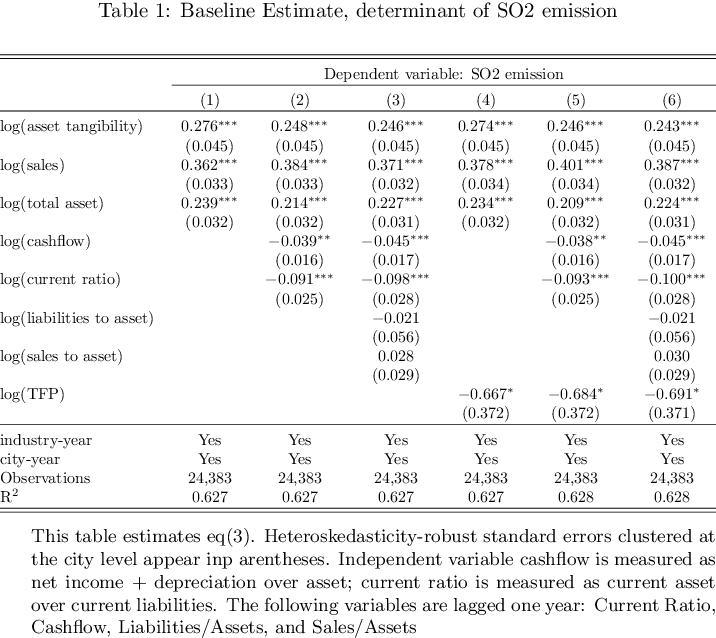

In [16]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

## Table 2: determinant of SO2 emission, polluted vs no polluted sectors

$$
\begin{aligned}
\text{SO2}_{cit}  &= \alpha \text{Financial ratio}_{ci} + \gamma_{ct} + \gamma_{ci}  + \epsilon_{cit}
\end{aligned}
$$

In [17]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [18]:
%get path table
t_0 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr, 
            df_final %>% 
            filter(polluted_d75i == 'ABOVE'),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr,
            df_final %>% 
            filter(polluted_d75i == 'BELOW'),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr, 
            df_final %>% 
            filter(polluted_d75i == 'ABOVE'),
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,
            df_final %>% 
            filter(polluted_d75i == 'BELOW'),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3
),
    title="determinant of SO2 emission, polluted vs no polluted sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

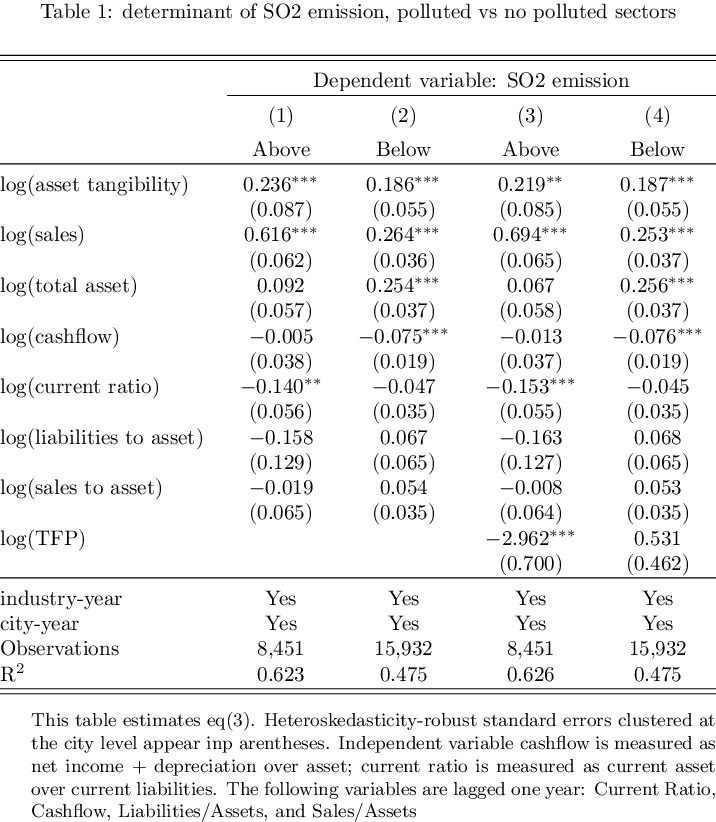

In [19]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Above', 'Below','Above', 'Below']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

## Table 3: Heterogeneity effect, city ownership public vs private/ Domestic vs foreign

City ownership are available for the following variables:

- output
- capital
- employment
- sales

**How is it constructed** 

* city ownership public vs private in 2002
  * Aggregate output by ownership and city
    * A given city will have SOE asset tangibility and PRIVATE asset tangibility [output, employment, capital and sales]
  * If asset tangibility SOE above Private then city is dominated by SOE
  
Notebook reference: https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/07_dominated_city_ownership.md

In [20]:
query = """
WITH test AS (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2,
    CASE WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS soe_vs_pri,
    CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS for_vs_dom 
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  
) 
SELECT year, soe, geocode4_corr, indu_2,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
SELECT *,
CASE WHEN ownership in ('SOE') THEN 'SOE' ELSE 'PRIVATE' END AS soe
FROM test 
  )
  GROUP BY soe, geocode4_corr, year, indu_2
"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

Dirty code

In [21]:
import janitor

In [22]:
for v in ['output','employ', 'capital']:
    for t in [.5, .4, .3, .2, .1]:
        df_ = (
            df
            .set_index(['year','indu_2', 'soe', 'geocode4_corr'])
            .unstack(-2)
            .assign(
                soe_dominated = lambda x: x[(v, 'SOE')] > x[(v, 'PRIVATE')],
                share_soe = lambda x: x[(v, 'SOE')] / (x[(v, 'SOE')] + x[(v, 'PRIVATE')])
            )
            #.loc[lambda x: x['soe_dominated'].isin([True])]
            .collapse_levels("_")
            .reset_index()
            [['year','geocode4_corr', 'indu_2', "soe_dominated", 
             'share_soe'
             ]]
            .loc[lambda x: x['year'].isin(["2002"])]
            .drop(columns = ['year'])
            .rename(columns = {'indu_2':'ind2'})
            .loc[lambda x: x['share_soe']> t]
            #.groupby(['soe_dominated'])
            #.agg({'share_soe':'describe'})
            .to_csv('list_city_soe_{}_{}.csv'.format(v, t))
        )

In [23]:
query = """
WITH test AS (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2,
    CASE WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS soe_vs_pri,
    CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS for_vs_dom 
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  
) 
SELECT year, foreign, geocode4_corr, indu_2,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
SELECT *,
CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS foreign
FROM test 
  )
  GROUP BY foreign, geocode4_corr, year, indu_2

"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

In [24]:
for v in ['output','employ', 'capital']:
    for t in [.5, .4, .3, .2, .1]:
        (
            df
            .set_index(['year','indu_2', 'foreign', 'geocode4_corr'])
            .unstack(-2)
            .assign(
                for_dominated = lambda x: x[(v, 'FOREIGN')] > x[(v, 'DOMESTIC')],
                share_for = lambda x: x[(v, 'FOREIGN')] / (x[(v, 'FOREIGN')] + x[(v, 'DOMESTIC')])
            )
            .collapse_levels("_")
            .reset_index()
            [['year','geocode4_corr', 'indu_2', "for_dominated", 
             'share_for'
             ]]
            .loc[lambda x: x['year'].isin(["2002"])]
            .drop(columns = ['year'])
            .rename(columns = {'indu_2':'ind2'})
            .loc[lambda x: x['share_for']> t]
            #.groupby(['soe_dominated'])
            #.agg({'share_soe':'describe'})
            .to_csv('list_city_for_{}_{}.csv'.format(v, t))
        )

In [25]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

Baseline: 50%

Manually save and rename tex file: table_3_output_5


In [26]:
%get path table
df_soe <- df_final %>% inner_join(read_csv('list_city_soe_employ_0.2.csv'))
df_priv <- df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>% filter(is.na(share_soe))
df_for <- df_final %>% inner_join(read_csv('list_city_for_employ_0.2.csv'))
df_dom <- df_final %>% left_join(read_csv('list_city_for_employ_0.2.csv')) %>% filter(is.na(share_for))
### SOE vs Private
t_0 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_soe,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_priv,
            exactDOF = TRUE)

## TFP
t_2 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_soe,
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_priv,
            exactDOF = TRUE)

## Domestic vs Foreign

t_4 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_for,
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_dom,
            exactDOF = TRUE)

## TFP
t_6 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_for,
            exactDOF = TRUE)
t_7 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_dom,
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5, t_6, t_7
),
    title="Heterogeneity effect, city ownership",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

Parsed with column specification:
cols(
  X1 = col_double(),
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  X1 = col_double(),
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  X1 = col_double(),
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  X1 = col_double(),
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")


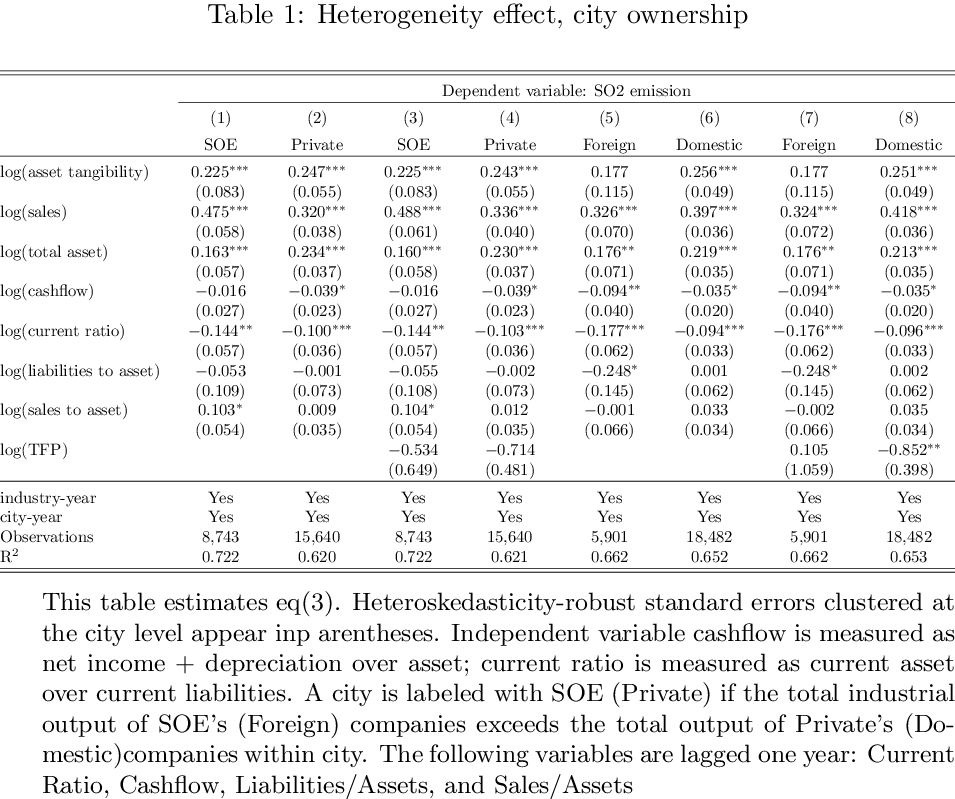

In [27]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& SOE', 'Private', 'SOE', 'Private', 'Foreign', 'Domestic', 'Foreign', 'Domestic']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

## Table 4: Heterogeneity effect, Environmental and industrial policy


In [28]:
folder = 'Tables_0'
table_nb = 4
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [29]:
%get path table
### TCZ
t_0 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 0),
            exactDOF = TRUE)

## TFP
t_2 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_final %>% filter(tcz == 0),
            exactDOF = TRUE)

### SPZ
t_4 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 1),
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) 
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 0),
            exactDOF = TRUE)

t_6 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_final %>% filter(spz == 1),
            exactDOF = TRUE)
t_7 <- felm(log(tso2) ~ 
            log(asset_tangibility_tot_asset) +
            log(sales) +
            log(total_asset) +
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset) +
            log(tfp_cit)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_final %>% filter(spz == 0),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5, t_6, t_7
),
    title="Heterogeneity effect, environmental and industrial policies",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

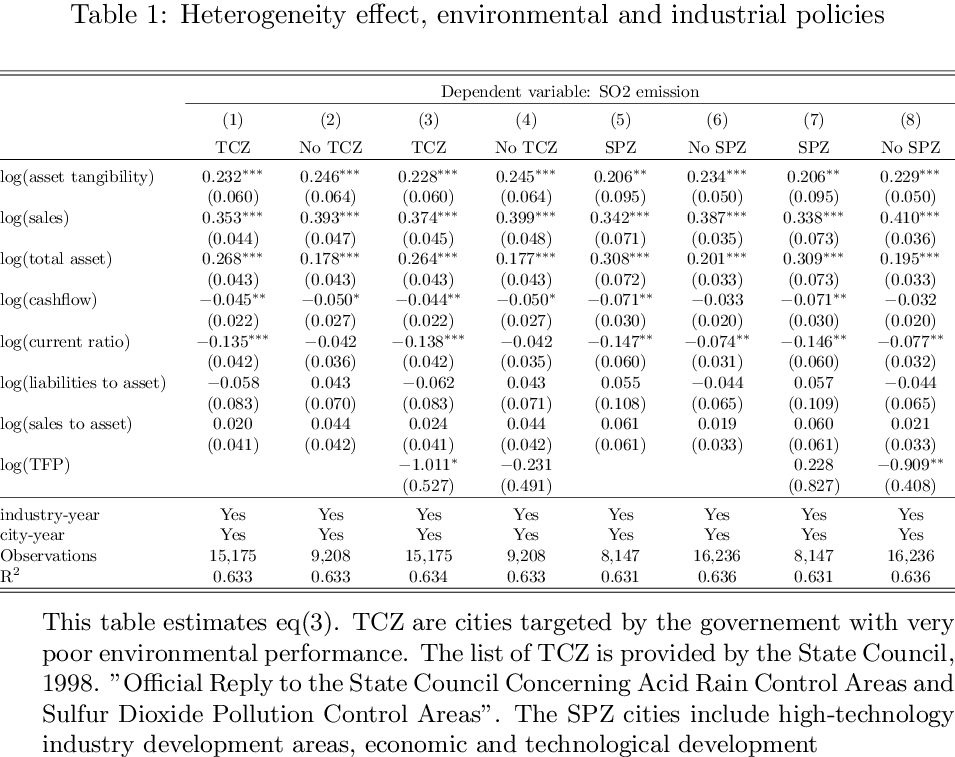

In [30]:
tbe1  = "This table estimates eq(3). " \
'TCZ are cities targeted by the governement with very poor environmental performance. ' \
'The list of TCZ is provided by the State Council, 1998. "Official Reply to the State Council Concerning ' \
'Acid Rain Control Areas and Sulfur Dioxide Pollution Control Areas". ' \
"The SPZ cities include high-technology industry development areas, economic and technological development "
"areas, and export processing zones. " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& TCZ', 'No TCZ', 'TCZ', 'No TCZ', 'SPZ', 'No SPZ','SPZ', 'No SPZ']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

In [ ]:
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = False, notebookname = "03_so2_fin_ratio_sector.ipynb")